# Barycenter of MNIST Digits

In [1]:

from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 
import itertools

## Download and open the MNIST dataset

In [2]:
import hashlib 
import os 
import requests 
import gzip

#fetch data (adapted from https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb)
path='./'
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

digits = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
labels = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]

### Plot a few samples of the digit we're interested in

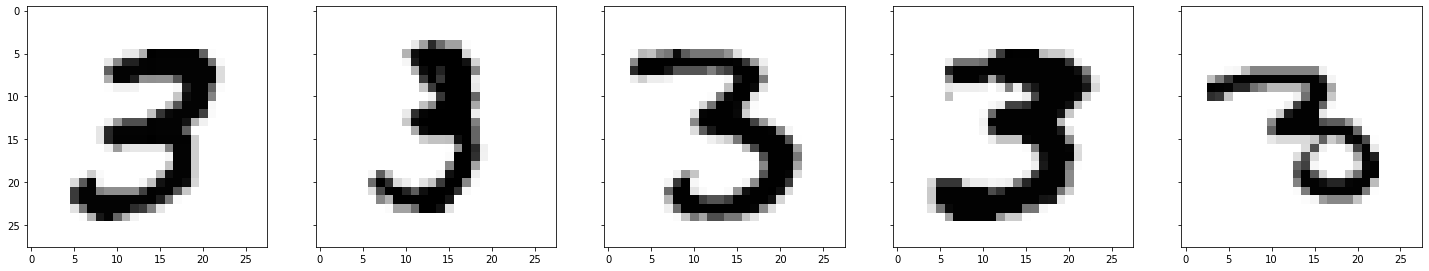

In [3]:
desired_digit = 3
inds = np.where(labels==desired_digit)[0]

num_plot = 5
fig,axs = plt.subplots(ncols=num_plot, sharey=True, figsize=(num_plot*5,5))
for i in range(num_plot):
    axs[i].imshow(digits[inds[i],:,:],cmap='Greys')


### Extract digits with similar total measure

In [4]:
# Grid of size n1 x n2
n1 = digits.shape[1]   # x axis
n2 = digits.shape[2]   # y axis

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

In [5]:
unroll_node = 0

num_digits = 10 
sums = np.array([np.sum(digits[i,:,:]) for i in inds])

val = np.sum(digits[inds[0],:,:])

sorted_inds = inds[np.argsort(np.abs(sums-val))]
measures = [digits[sorted_inds[i],:,:]* (n1*n2/np.sum(digits[sorted_inds[i],:,:])) for i in range(num_digits)]

### Define the edge list for the barycenter problem

In [6]:

edge_list = []
for i in range(num_digits):
    for j in range(i+1,num_digits):
        edge_list += [[i,j]]

weights = np.ones(num_digits)/num_digits
prob = MMOTSolver(measures, edge_list, x, y, unroll_node, weights)

### Solve the problem

In [7]:
res = prob.Solve(max_its=10000, step_size=0.2, ftol_abs=1e-9, gtol_abs=1e-3)


Iteration, StepSize,        Cost,        Error,  Line Its
        0,   0.0008,  2.9718e-05,   6.4792e-01,         8
       10,   0.0024,  1.0481e-03,   2.1600e-01,         1
       20,   0.0005,  1.3669e-03,   5.9153e-02,         2
       30,   0.0007,  1.4992e-03,   5.2840e-02,         0
       40,   0.0006,  1.6109e-03,   3.5748e-02,         0
       50,   0.0004,  1.7105e-03,   3.2587e-02,         0
       60,   0.0003,  1.7732e-03,   3.4393e-02,         0
       70,   0.0003,  1.8233e-03,   3.1682e-02,         0
       80,   0.0002,  1.8700e-03,   3.0405e-02,         0
       90,   0.0003,  1.9148e-03,   3.0622e-02,         0
      100,   0.0001,  1.9598e-03,   3.2687e-02,         0
      110,   0.0001,  1.9703e-03,   3.0325e-02,         0
      120,   0.0001,  1.9875e-03,   2.9813e-02,         1
      130,   0.0001,  2.0018e-03,   3.0247e-02,         1
      140,   0.0000,  2.0093e-03,   3.0281e-02,         0
      150,   0.0000,  2.0168e-03,   2.9440e-02,         0
      160,   0

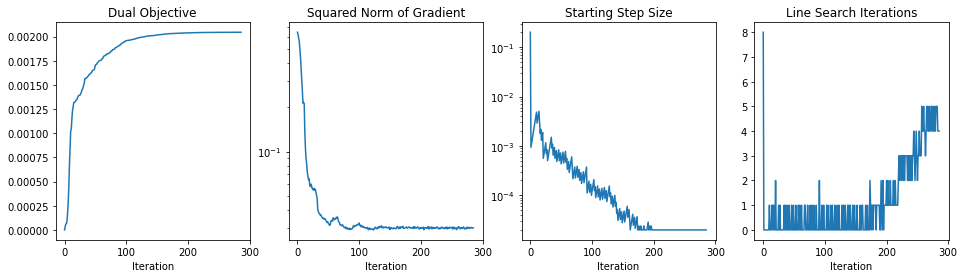

In [8]:

    
fig, axs = plt.subplots(ncols=4,sharex=True,figsize=(16,4))
axs[0].plot(res.costs)
axs[0].set_title('Dual Objective')
axs[0].set_xlabel('Iteration')

axs[1].semilogy(res.grad_sq_norms)
axs[1].set_title('Squared Norm of Gradient')
axs[1].set_xlabel('Iteration')

axs[2].semilogy(res.step_sizes)
axs[2].set_title('Starting Step Size')
axs[2].set_xlabel('Iteration')

axs[3].plot(res.line_its)
axs[3].set_title('Line Search Iterations')
axs[3].set_xlabel('Iteration')

plt.show()

### Compute the Barycenter

In [9]:

bary = prob.Barycenter(res.dual_vars)

### Plot the images used and the barycenter

Text(0.5, 1.0, 'Barycenter')

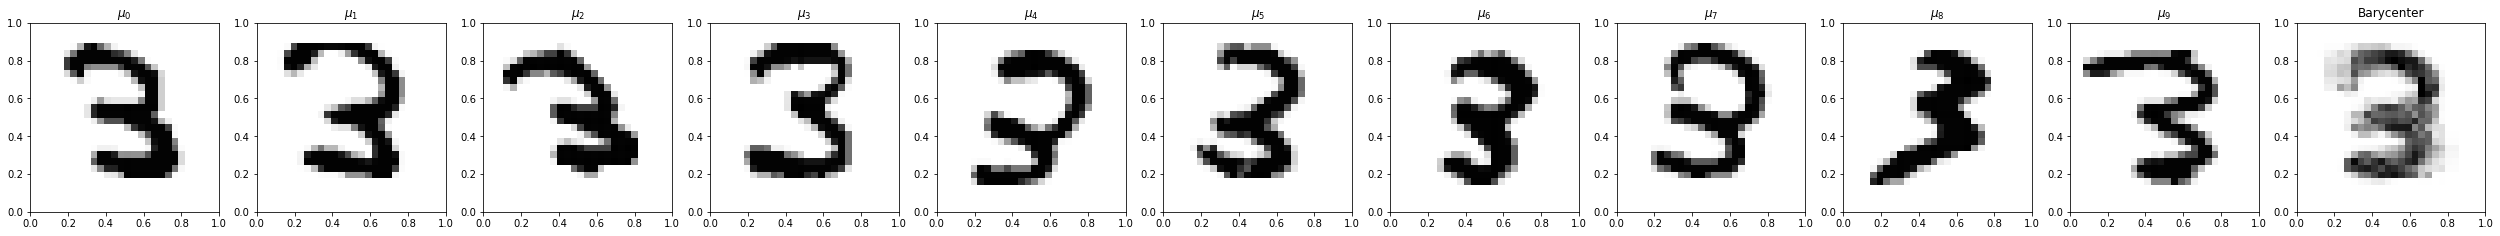

In [10]:
vmax = np.max([np.max(m) for m in measures])
fig, axs = plt.subplots(1, num_digits+1, figsize=((num_digits+1)*4,4))
for i in range(num_digits):
    axs[i].imshow(measures[i], origin='lower', extent=(0,1,0,1), vmin=0, vmax=vmax, cmap='Greys')
    axs[i].set_title("$\\mu_{{ {:0d} }}$".format(i))
    
axs[-1].imshow(bary, origin='lower', extent=(0,1,0,1), vmin=0, vmax=vmax, cmap='Greys')
axs[-1].set_title('Barycenter')